# Session 4: Convolutional Neural Networks for Sequences
## PyTorch CNNs for Genomics - Motif Detection and Feature Extraction

**📖 Book References**: Deep Learning with PyTorch Ch. 8 (pages 245-290), Gen AI Ch. 4  
**⏱️ Duration**: 3-4 hours  
**🎯 Difficulty**: Intermediate

---

## 🎯 Learning Objectives & Core Functions

### What You'll Learn:
✅ 1D convolutions for DNA/protein sequences  
✅ Multi-kernel architectures for motif detection  
✅ Pooling operations (max, average, global)  
✅ Build DeepBind-style models  
✅ Visualize learned filters as PWMs  
✅ Extract sequence features automatically

### Core PyTorch Functions:

In [ ]:
nn.Conv1d(in_channels, out_channels, kernel_size)
nn.MaxPool1d(kernel_size)
nn.AvgPool1d(kernel_size)
nn.AdaptiveMaxPool1d(output_size)
nn.BatchNorm1d(num_features)
F.conv1d()  # Functional interface

---

## 📚 Quick Theory

### Why CNNs for Sequences?

**DNA/Protein sequences have**:
- Local patterns (motifs, binding sites)
- Translation invariance (motifs can occur anywhere)
- Hierarchical features (motifs → domains → functions)

**CNNs provide**:
- Parameter sharing across positions
- Automatic feature learning
- Much fewer parameters than fully connected

### 1D Convolution:

In [ ]:
Sequence: ATCGATCG (one-hot encoded to 4xL)
Kernel: 4x3 (4 channels, width 3)
Output: Detections at each position

---

## 🧪 Exercise 1: Basic 1D Convolution

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# One-hot encode DNA
def one_hot_encode(seq):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    encoding = np.zeros((4, len(seq)))
    for i, base in enumerate(seq):
        if base in mapping:
            encoding[mapping[base], i] = 1
    return torch.FloatTensor(encoding).unsqueeze(0)

# Test sequence
seq = "ATCGATCG" * 10
X = one_hot_encode(seq)
print(f"Encoded shape: {X.shape}")  # (1, 4, length)

# Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, kernel_size=8):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 16, kernel_size)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        return x

model = SimpleCNN()
output = model(X)
print(f"Output shape: {output.shape}")

Encoded shape: torch.Size([1, 4, 80])
Output shape: torch.Size([1, 32, 29])


---

## 🧪 Exercise 2: Motif Detector

In [3]:
# Generate data with known motif
def generate_sequences_with_motif(n_samples=1000, seq_len=50, motif="TATAAA"):
    sequences = []
    labels = []

    for _ in range(n_samples // 2):
        # Positive: contains motif
        pos = np.random.randint(0, seq_len - len(motif))
        seq = list(np.random.choice(['A','C','G','T'], seq_len))
        seq[pos:pos+len(motif)] = list(motif)
        sequences.append(''.join(seq))
        labels.append(1)

        # Negative: random
        seq = ''.join(np.random.choice(['A','C','G','T'], seq_len))
        sequences.append(seq)
        labels.append(0)

    return sequences, labels

sequences, labels = generate_sequences_with_motif()
X = torch.stack([one_hot_encode(s).squeeze(0) for s in sequences])
y = torch.FloatTensor(labels)

print(f"Data: {X.shape}, Labels: {y.shape}")

# CNN Motif Detector
class MotifCNN(nn.Module):
    def __init__(self, kernel_size=8, n_kernels=32):
        super().__init__()
        self.conv = nn.Conv1d(4, n_kernels, kernel_size)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(n_kernels, 1)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x).squeeze(-1)
        x = torch.sigmoid(self.fc(x))
        return x.squeeze()

model = MotifCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
for epoch in range(50):
    optimizer.zero_grad()
    predictions = model(X)
    loss = criterion(predictions, y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        acc = ((predictions > 0.5) == y).float().mean()
        print(f"Epoch {epoch+1}: Loss={loss:.4f}, Acc={acc:.4f}")

Data: torch.Size([1000, 4, 50]), Labels: torch.Size([1000])
Epoch 10: Loss=0.6866, Acc=0.6110
Epoch 20: Loss=0.6762, Acc=0.7240
Epoch 30: Loss=0.6633, Acc=0.8000
Epoch 40: Loss=0.6466, Acc=0.8520
Epoch 50: Loss=0.6250, Acc=0.8880


---

## 🧪 Exercise 3: Multi-Scale CNN

In [43]:
class MultiScaleCNN(nn.Module):
    def __init__(self, kernel_sizes=[6, 8, 10, 12]):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(4, 32, k) for k in kernel_sizes
        ])
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(32 * len(kernel_sizes), 1)

    def forward(self, x):
        conv_outputs = []
        for conv in self.convs:
            out = F.relu(conv(x))
            out = self.pool(out)
            conv_outputs.append(out)

        x = torch.cat(conv_outputs, dim=1).squeeze(-1)
        x = torch.sigmoid(self.fc(x))
        return x.squeeze()

model = MultiScaleCNN()
print(model)

# Train similar to above

MultiScaleCNN(
  (convs): ModuleList(
    (0): Conv1d(4, 32, kernel_size=(6,), stride=(1,))
    (1): Conv1d(4, 32, kernel_size=(8,), stride=(1,))
    (2): Conv1d(4, 32, kernel_size=(10,), stride=(1,))
    (3): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  )
  (pool): AdaptiveMaxPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


---

## 🧪 Exercise 4: Visualize Learned Filters

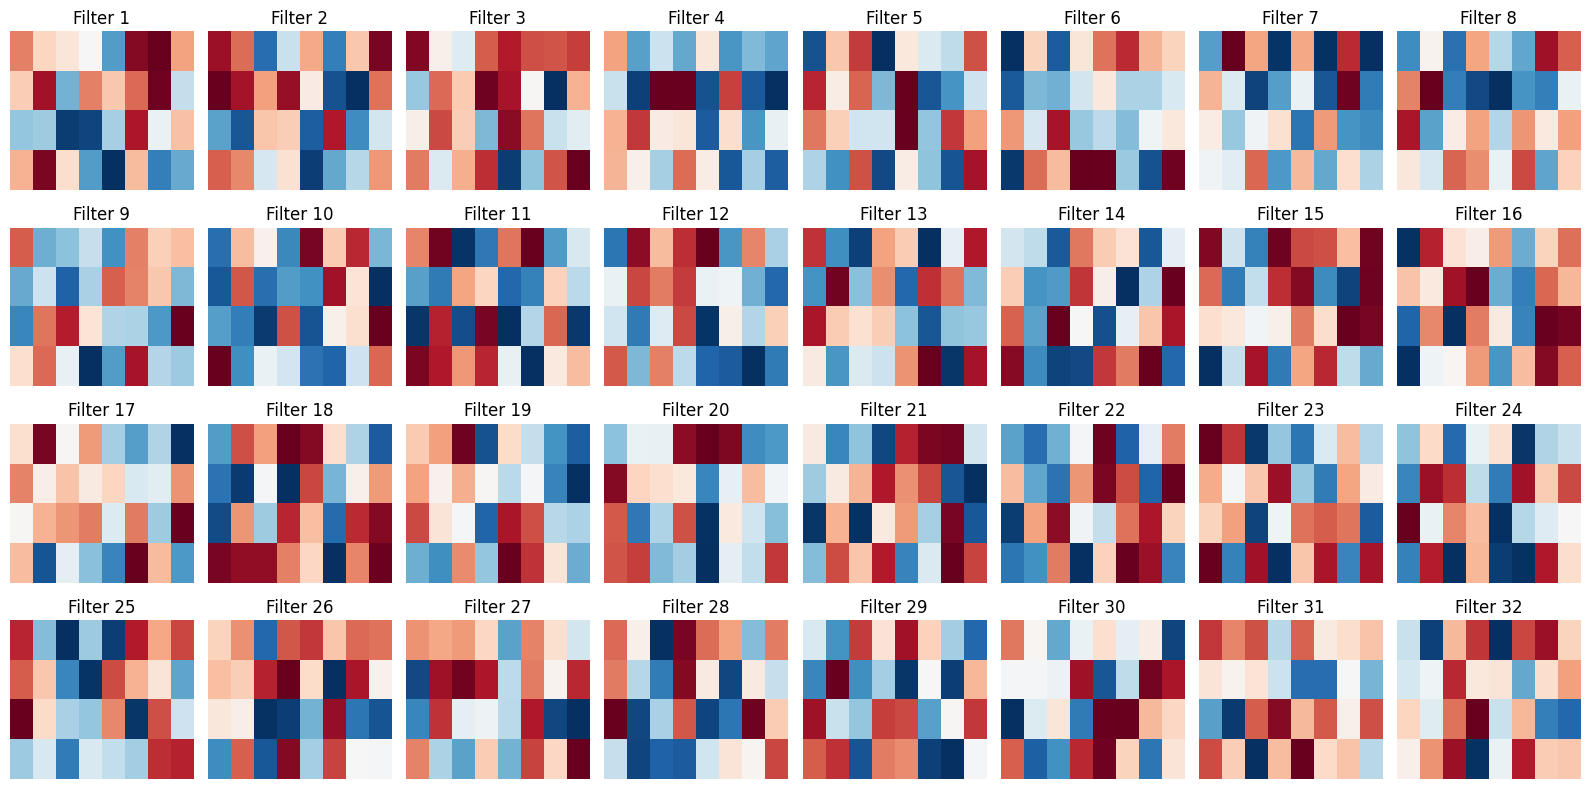

In [4]:
def visualize_conv_filters(model):
    # Get first conv layer weights
    weights = model.conv.weight.data
    n_filters = weights.shape[0]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Convert to PWM-like
            filter_weights = weights[i].numpy()
            ax.imshow(filter_weights, aspect='auto', cmap='RdBu_r')
            ax.set_title(f'Filter {i+1}')
            ax.set_yticks([0,1,2,3])
            ax.set_yticklabels(['A','C','G','T'])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

model = MotifCNN()
# Train model first...
visualize_conv_filters(model)

---

## 🧪 Exercise 5: Splice Site Prediction

In [8]:
# More complex task: predict splice sites
class SpliceSiteCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 64, kernel_size=11)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=7)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 3)  # 3 classes: donor, acceptor, neither

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x).squeeze(-1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SpliceSiteCNN()
print(f"Parameters: {sum(p.numel() for p in model.parameters())}")

Parameters: 34051


Improved Models for Splice Site Prediction


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedSpliceSiteCNN(nn.Module):
    """
    Improved CNN for splice site prediction.

    Key improvements:
    1. Wider receptive field (sees more context)
    2. Position-aware architecture
    3. Multiple scales for different splice patterns
    4. Proper output for classification
    """
    def __init__(self, seq_length=200):
        super().__init__()

        # First conv block - local patterns
        self.conv1 = nn.Conv1d(4, 64, kernel_size=11, padding=5)  # Keep length
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)  # Downsample by 2

        # Second conv block - motif combinations
        self.conv2 = nn.Conv1d(64, 128, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)  # Downsample by 2

        # Third conv block - high-level features
        self.conv3 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Classifier
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 3)  # donor, acceptor, neither

    def forward(self, x):
        # Feature extraction
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))

        # Global features
        x = self.global_pool(x).squeeze(-1)

        # Classification
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)  # Raw logits (use with CrossEntropyLoss)

        return x


class PositionAwareSpliceCNN(nn.Module):
    """
    Position-aware splice site predictor.

    Splice sites have strong positional signals:
    - Donor: GT at specific position
    - Acceptor: AG at specific position

    This model preserves positional information better.
    """
    def __init__(self, seq_length=200):
        super().__init__()
        self.seq_length = seq_length

        # Multi-scale convolutions (like motif detector)
        self.conv_small = nn.Conv1d(4, 32, kernel_size=7, padding=3)
        self.conv_medium = nn.Conv1d(4, 32, kernel_size=11, padding=5)
        self.conv_large = nn.Conv1d(4, 32, kernel_size=15, padding=7)

        # Batch norms
        self.bn_small = nn.BatchNorm1d(32)
        self.bn_medium = nn.BatchNorm1d(32)
        self.bn_large = nn.BatchNorm1d(32)

        # Combine multi-scale features
        self.conv_combine = nn.Conv1d(96, 128, kernel_size=5, padding=2)
        self.bn_combine = nn.BatchNorm1d(128)

        # Attention mechanism (focus on important positions)
        self.attention = nn.Conv1d(128, 1, kernel_size=1)

        # Final convolution before pooling
        self.conv_final = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn_final = nn.BatchNorm1d(256)

        # Classifier
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        # Multi-scale feature extraction
        x_small = F.relu(self.bn_small(self.conv_small(x)))
        x_medium = F.relu(self.bn_medium(self.conv_medium(x)))
        x_large = F.relu(self.bn_large(self.conv_large(x)))

        # Concatenate multi-scale features
        x = torch.cat([x_small, x_medium, x_large], dim=1)

        # Combine features
        x = F.relu(self.bn_combine(self.conv_combine(x)))

        # Attention weights (which positions matter most)
        attention_weights = torch.softmax(self.attention(x), dim=-1)
        x = x * attention_weights  # Weight features by importance

        # Final features
        x = F.relu(self.bn_final(self.conv_final(x)))

        # Pool and classify
        x = self.pool(x).squeeze(-1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x


class BiDirectionalSpliceCNN(nn.Module):
    """
    Bidirectional CNN for splice sites.
    Processes sequence in both directions (like BiLSTM).
    """
    def __init__(self):
        super().__init__()

        # Forward direction
        self.forward_conv1 = nn.Conv1d(4, 64, kernel_size=11, padding=5)
        self.forward_conv2 = nn.Conv1d(64, 128, kernel_size=7, padding=3)

        # Reverse direction
        self.reverse_conv1 = nn.Conv1d(4, 64, kernel_size=11, padding=5)
        self.reverse_conv2 = nn.Conv1d(64, 128, kernel_size=7, padding=3)

        # Batch norms
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn_combine = nn.BatchNorm1d(256)

        # Combine bidirectional features
        self.conv_combine = nn.Conv1d(256, 256, kernel_size=3, padding=1)

        # Classifier
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # Forward direction
        x_fwd = F.relu(self.bn1(self.forward_conv1(x)))
        x_fwd = F.relu(self.bn2(self.forward_conv2(x_fwd)))

        # Reverse direction
        x_rev = torch.flip(x, dims=[2])  # Reverse sequence
        x_rev = F.relu(self.bn1(self.reverse_conv1(x_rev)))
        x_rev = F.relu(self.bn2(self.reverse_conv2(x_rev)))
        x_rev = torch.flip(x_rev, dims=[2])  # Flip back

        # Combine both directions
        x = torch.cat([x_fwd, x_rev], dim=1)
        x = F.relu(self.bn_combine(self.conv_combine(x)))

        # Classify
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


# Complete training pipeline
def train_splice_site_predictor(model, train_loader, val_loader,
                                 epochs=50, lr=0.001, device='cpu'):
    """
    Training loop for splice site prediction.
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()  # For multi-class
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    best_val_acc = 0.0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = 100 * train_correct / train_total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        # Class-wise accuracy
        class_correct = [0, 0, 0]
        class_total = [0, 0, 0]

        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)

                outputs = model(sequences)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Track per-class accuracy
                for i in range(len(labels)):
                    label = labels[i].item()
                    class_total[label] += 1
                    if predicted[i] == labels[i]:
                        class_correct[label] += 1

        val_acc = 100 * val_correct / val_total
        scheduler.step(val_loss)

        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"\nEpoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.2f}%")
            print("Per-class accuracy:")
            print(f"  Donor: {100*class_correct[0]/class_total[0]:.2f}%")
            print(f"  Acceptor: {100*class_correct[1]/class_total[1]:.2f}%")
            print(f"  Neither: {100*class_correct[2]/class_total[2]:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_splice_model.pth')

    return model


# Usage example
if __name__ == "__main__":
    # Model comparison
    print("="*60)
    print("Model Architecture Comparison")
    print("="*60)

    models = {
        "Original": SpliceSiteCNN(),
        "Improved": ImprovedSpliceSiteCNN(),
        "Position-Aware": PositionAwareSpliceCNN(),
        "Bidirectional": BiDirectionalSpliceCNN()
    }

    for name, model in models.items():
        params = sum(p.numel() for p in model.parameters())
        print(f"\n{name}:")
        print(f"  Parameters: {params:,}")

        # Test forward pass
        dummy_input = torch.randn(8, 4, 200)  # batch=8, channels=4, length=200
        output = model(dummy_input)
        print(f"  Output shape: {output.shape}")
        print(f"  Expected: (8, 3) for 3 classes")

combining both positional and channel weighting

In [ ]:
class BetterSpliceCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(4, 128, kernel_size=11, padding=5)

        # Spatial: which positions matter
        self.spatial_weight = nn.Conv1d(128, 1, kernel_size=1)

        # Channel: which features matter
        self.channel_weight = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(128, 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(16, 128, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = F.relu(self.conv(x))

        # Apply channel attention
        ca = self.channel_weight(x)
        x = x * ca

        # Apply spatial weighting
        sw = torch.softmax(self.spatial_weight(x), dim=-1)
        x = x * sw

        return x


---

## 🎯 Challenge: DeepBind Replication

Build a model similar to DeepBind for TF binding prediction.

In [ ]:
class DeepBindModel(nn.Module):
    def __init__(self, seq_len=101, n_motifs=16, motif_len=24):
        super().__init__()
        self.conv = nn.Conv1d(4, n_motifs, motif_len)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=3)

        # Calculate flattened size
        conv_out_len = seq_len - motif_len + 1
        pool_out_len = (conv_out_len - 3) // 3 + 1
        flat_size = n_motifs * pool_out_len

        self.fc1 = nn.Linear(flat_size, 32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()

model = DeepBindModel()
# Train on ChIP-seq data...

---

## ✅ Self-Assessment

- [ ] Understand 1D convolution for sequences
- [ ] Can explain kernel size vs receptive field
- [ ] Know when to use pooling
- [ ] Built multi-kernel architectures
- [ ] Visualized learned filters
- [ ] Applied to real genomics tasks

---

## 📝 Key Takeaways

- **Conv1d**: Perfect for sequence data
- **Multiple kernels**: Detect different patterns
- **Pooling**: Downsample and aggregate
- **Adaptive pooling**: Fixed output size
- **Batch norm**: Faster, more stable training

---

*Session 4 Complete!*